In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files
import pandas as pd
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

output = widgets.Output()

upload_button = widgets.Button(
    description='📤 Subir archivo CSV',
    layout=widgets.Layout(width='200px', height='40px'),
    button_style='primary'
)

def on_upload_clicked(b):
    clear_output()
    uploaded = files.upload()
    for nombre_archivo in uploaded.keys():
        df = pd.read_csv(io.BytesIO(uploaded[nombre_archivo]))
        print(f"✅ Archivo cargado: {nombre_archivo}")
        print(f"📊 Dimensiones del DataFrame: {df.shape}")
        print(df.head())
        globals()['df'] = df  # hace df accesible globalmente

upload_button.on_click(on_upload_clicked)

display(upload_button, output)


Saving datos_100_estudiantes.csv to datos_100_estudiantes (4).csv
✅ Archivo cargado: datos_100_estudiantes (4).csv
📊 Dimensiones del DataFrame: (100, 8)
   horas_sueno  tareas_tarde  horas_pantalla  descansos_dia  estres_auto  \
0     6.996714             1        6.451280              3            4   
1     6.361736             0        7.486774              5            2   
2     7.147689             2        4.364973              1            1   
3     8.023030             2       10.155647              2            1   
4     6.265847             3        7.036361              0            2   

   actividades_extras  interaccion_social  cambios_animo  
0                   3                   4              1  
1                   2                   5              1  
2                   2                   4              5  
3                   0                   5              3  
4                   3                   5              3  


In [ ]:

np.random.seed(42)
num_samples = 100

datos = {
    "horas_sueno": np.random.normal(6.5, 1.0, num_samples).clip(3, 10),
    "tareas_tarde": np.random.poisson(2, num_samples).clip(0, 10),
    "horas_pantalla": np.random.normal(7.5, 1.5, num_samples).clip(2, 14),
    "descansos_dia": np.random.randint(0, 6, num_samples),
    "estres_auto": np.random.randint(1, 6, num_samples),
    "actividades_extras": np.random.randint(0, 4, num_samples),
    "interaccion_social": np.random.randint(1, 6, num_samples),
    "cambios_animo": np.random.randint(1, 6, num_samples)
}

df = pd.DataFrame(datos)

def clasificar_burnout(row):
    score = (
        (6 - row["horas_sueno"]) * 1.2 +
        row["tareas_tarde"] * 0.7 +
        (row["horas_pantalla"] - 6) * 0.8 +
        (5 - row["descansos_dia"]) * 0.6 +
        row["estres_auto"] * 1.5 +
        (5 - row["interaccion_social"]) * 0.5 +
        row["cambios_animo"] * 1.0
    )
    if score < 6:
        return 0
    elif score < 10:
        return 1
    elif score < 14:
        return 2
    else:
        return 3

df["nivel_burnout"] = df.apply(clasificar_burnout, axis=1)
df.head()


,horas_sueno,tareas_tarde,horas_pantalla,descansos_dia,estres_auto,actividades_extras,interaccion_social,cambios_animo,nivel_burnout
0,6.996714,1,6.451280,3,4,3,4,1,1
1,6.361736,0,7.486774,5,2,2,5,1,0
2,7.147689,2,4.364973,1,1,2,4,5,1
3,8.023030,2,10.155647,2,1,0,5,3,1
4,6.265847,3,7.036361,0,2,3,5,3,2


In [ ]:
X = df.drop("nivel_burnout", axis=1).values
y = df["nivel_burnout"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_cat = to_categorical(y, num_classes=4)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42)


In [ ]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(8,)),
    Dense(12, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=0)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_split=0.2,
                    callbacks=[early_stop], verbose=0)


loss, acc = model.evaluate(X_test, y_test)
print(f"Precisión del modelo: {acc:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7500 - loss: 0.5014
Precisión del modelo: 0.75


In [ ]:
# Evaluación detallada del modelo
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Matriz de confusión:
[[3 0 0]
 [2 8 2]
 [0 1 4]]

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.60      1.00      0.75         3
           2       0.89      0.67      0.76        12
           3       0.67      0.80      0.73         5

    accuracy                           0.75        20
   macro avg       0.72      0.82      0.75        20
weighted avg       0.79      0.75      0.75        20



In [ ]:
df_nuevos = df.copy()  # o usa df directamente

# Drop the target variable column from the new data before scaling
X_nuevos = scaler.transform(df_nuevos.drop("nivel_burnout", axis=1))
predicciones = model.predict(X_nuevos)
niveles_predichos = np.argmax(predicciones, axis=1)

niveles = ["Sin riesgo", "Riesgo leve", "Riesgo moderado", "Riesgo alto"]
print("\nResultados de predicción:")
for i, nivel in enumerate(niveles_predichos):
    print(f"Estudiante {i+1}: {niveles[nivel]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Resultados de predicción:
Estudiante 1: Riesgo leve
Estudiante 2: Riesgo leve
Estudiante 3: Riesgo leve
Estudiante 4: Riesgo leve
Estudiante 5: Riesgo leve
Estudiante 6: Riesgo moderado
Estudiante 7: Riesgo leve
Estudiante 8: Riesgo leve
Estudiante 9: Riesgo alto
Estudiante 10: Riesgo alto
Estudiante 11: Riesgo moderado
Estudiante 12: Riesgo alto
Estudiante 13: Riesgo leve
Estudiante 14: Riesgo moderado
Estudiante 15: Riesgo leve
Estudiante 16: Riesgo alto
Estudiante 17: Riesgo leve
Estudiante 18: Riesgo moderado
Estudiante 19: Riesgo moderado
Estudiante 20: Riesgo leve
Estudiante 21: Riesgo moderado
Estudiante 22: Riesgo moderado
Estudiante 23: Riesgo alto
Estudiante 24: Riesgo moderado
Estudiante 25: Riesgo alto
Estudiante 26: Riesgo alto
Estudiante 27: Riesgo leve
Estudiante 28: Sin riesgo
Estudiante 29: Riesgo moderado
Estudiante 30: Riesgo moderado
Estudiante 31: Riesgo alto
Estudiante 32: Riesgo moderado
Estudiante 33: Riesgo moderado
Estudiante 34: Riesgo leve
Estudiante 35: Ri

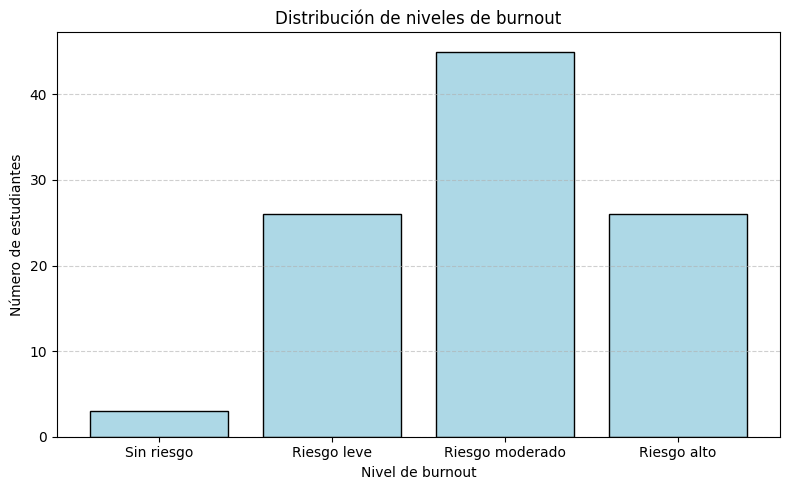

In [ ]:
import matplotlib.pyplot as plt
import collections

# Contar cuántos estudiantes hay por nivel
conteo_niveles = collections.Counter(niveles_predichos)

# Definir etiquetas legibles
etiquetas = ["Sin riesgo", "Riesgo leve", "Riesgo moderado", "Riesgo alto"]
valores = [conteo_niveles[i] for i in range(4)]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(etiquetas, valores, color='lightblue', edgecolor='black')
plt.title("Distribución de niveles de burnout")
plt.xlabel("Nivel de burnout")
plt.ylabel("Número de estudiantes")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
